<a href="https://colab.research.google.com/github/adamwatts112358/Python-Notebooks/blob/master/Tomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
% reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from skimage.transform import iradon_sart
from skimage.transform import iradon
from google.colab import files
mpl.rc('font',family='Times New Roman')

In [113]:
# Check versions

import platform
print('Python '+platform.python_version())

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

Python 3.6.8
matplotlib: 3.0.3


In [0]:
nparticles = 10000
sigmax = 0.005
sigmaxp = sigmax/4
x0 = np.random.normal(0,sigmax,nparticles)

In [0]:
num_wires = 48
wire_pitch = 0.001
low_x_lim = -(num_wires/2)*wire_pitch
high_x_lim = (num_wires/2)*wire_pitch
binBoundaries = np.linspace(low_x_lim,high_x_lim,num_wires+1)

xp0 = 0.5*x0 + np.random.normal(0,sigmaxp,nparticles)
#xp0 = -30*x0**2 + 0.8*x0 + np.random.normal(0,sigmaxp,10000)
#xp0 = 7000*x0**3 + 0.2*x0 + np.random.normal(0,sigmaxp,10000)

In [0]:
def getTwiss(x,xp):
    x = np.asarray(x)
    xp = np.asarray(xp)
    
    s11 = np.mean(x**2)
    s12 = np.mean(x*xp)
    s22 = np.mean(xp**2)
    
    epsilon = (s11*s22 - s12**2)**0.5
    beta = s11/epsilon
    alpha = -s12/epsilon
    gamma = s22/epsilon#(1+alpha**2)/beta

    return alpha, beta, gamma, 1*epsilon
alpha, beta, gamma, epsilon = getTwiss(x0,xp0)
alpha0 = alpha
beta0 = beta
epsilon0 = epsilon

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


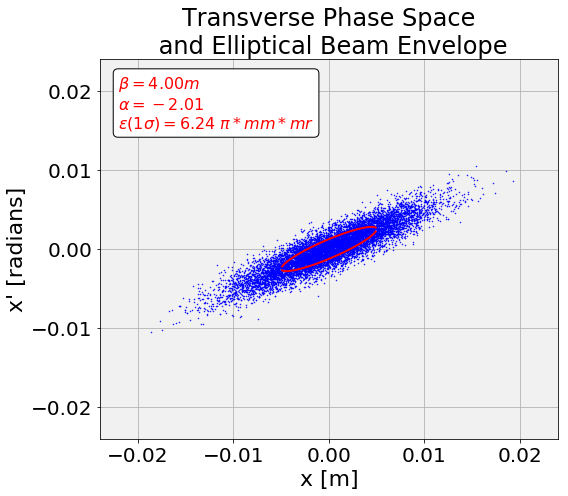

In [117]:
plt.figure(figsize=(8,7))
plt.plot(x0,xp0,'bo',markersize=0.5)
plt.title('Transverse Phase Space\n and Elliptical Beam Envelope',fontsize=24)
plt.xlim(-0.024,0.024)
plt.ylim(-0.024,0.024)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel("x\' [radians]",fontsize=22)
plt.grid()
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.gca().set_facecolor('#f1f1f1')

x_ellipse = np.linspace(-(epsilon*beta)**0.5,(epsilon*beta)**0.5,100)
xp_pos = (1/beta)*(-alpha*x_ellipse + (alpha**2*x_ellipse**2+beta*epsilon-beta*gamma*x_ellipse**2)**0.5)
xp_neg = (1/beta)*(-alpha*x_ellipse - (alpha**2*x_ellipse**2+beta*epsilon-beta*gamma*x_ellipse**2)**0.5)
plt.plot(x_ellipse,xp_pos,'r',linewidth=2)
plt.plot(x_ellipse,xp_neg,'r',linewidth=2)

textstr = r'$\beta = %.2f m$'%(beta)+'\n'+r'$\alpha = %.2f$'%(alpha)+'\n'+r'$\epsilon (1\sigma) = %.2f$'%(epsilon*1E6)+r' $\pi*mm*mr$'

plt.text(0.04, 0.82, textstr, transform=plt.gca().transAxes, fontsize=16, color='red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.tight_layout() 
plt.show()

In [0]:
def beamline(k,x,xp,binBoundaries,num_wires,wire_pitch):
    L = 1 # drift length [m]
    l = 1 # magnet length [m]
    O = np.array([[1,L],[0,1]])
    F = np.array([[np.cos(k**0.5),(k**-0.5)*np.sin(k**0.5)],[-(k**0.5)*np.sin(k**0.5),np.cos(k**0.5)]])
    D = np.array([[np.cosh(k**0.5),(k**-0.5)*np.sinh(k**0.5)],[-(k**0.5)*np.sinh(k**0.5),np.cosh(k**0.5)]])
    #F = np.array([[1,0],[-k*l,1]])
    #D = np.array([[1,0],[k*l,1]])
    
    R = np.linalg.multi_dot([O,D,O,F,O,D,O,F,O,D,O,F])
    
    xnew = R[0][0]*x + R[0][1]*xp
    xpnew = R[1][0]*x + R[1][1]*xp
    
    plt.clf()
    histarray = plt.hist(xnew,bins=binBoundaries)[0]
    plt.title("Simulated multiwire beam profile")
    plt.xlabel('x [m]')
    plt.ylabel('# of particles')
    plt.grid()
    
    theta = np.arctan(R[0][1]/R[0][0])
    s = np.sqrt(R[0][0]**2+R[0][1]**2)
    
    return xnew, histarray, theta, s

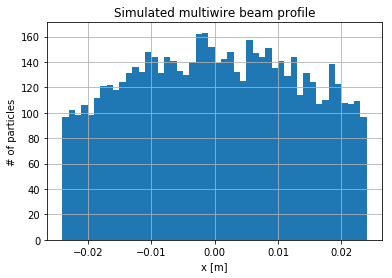

In [119]:
k_array = np.linspace(0.315,0.91,50)
theta_array = []
sarray = []
xarray = []
profiles = []
for k in k_array:
    x, d, th, s = beamline(k,x0,xp0,binBoundaries,num_wires,wire_pitch)
    theta_array.append(th)
    sarray.append(s)
    xarray.append(x)
    profiles.append(d)

Text(0.5, 1.0, 'Original profiles')

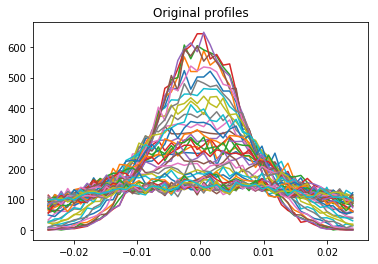

In [120]:
x_axis = np.linspace(-(num_wires/2)*wire_pitch,(num_wires/2)*wire_pitch,num_wires,1)

for p in profiles:
    plt.plot(x_axis,p)
plt.title('Original profiles')

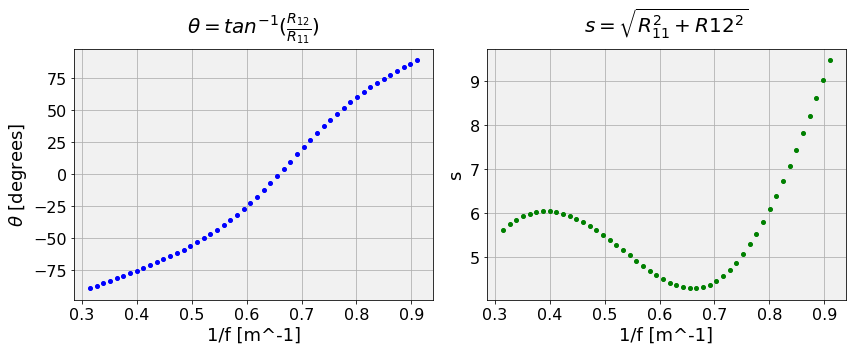

In [121]:
theta_array_degrees = np.asarray(theta_array)*(180/np.pi)
np.save("theta_array_degrees",theta_array_degrees)
np.save("sarray",sarray)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title(r'$\theta = tan^{-1}(\frac{R_{12}}{R_{11}})$',fontsize=20,y=1.04)
plt.plot(k_array,theta_array_degrees,'bo',markersize=4.0);
plt.xlabel('1/f [m^-1]',fontsize=18)
plt.ylabel(r'$\theta$ [degrees]',fontsize=18)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
plt.grid()
plt.gca().set_facecolor('#f1f1f1')


plt.subplot(122)
plt.title(r'$s = \sqrt{R_{11}^2 + R{12}^2}$',fontsize=20,y=1.04)
plt.plot(k_array,sarray,'go',markersize=4.0);
plt.xlabel('1/f [m^-1]',fontsize=18)
plt.ylabel('s',fontsize=18)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
plt.grid()
plt.gca().set_facecolor('#f1f1f1')


plt.tight_layout()

Text(0.5, 1.0, 'Scaled profiles')

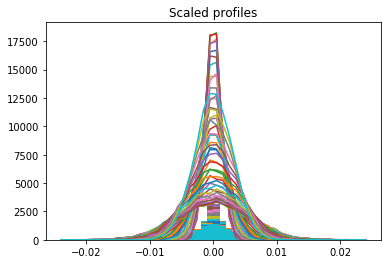

In [122]:
x_axis = np.linspace(-(num_wires/2)*wire_pitch,(num_wires/2)*wire_pitch,num_wires,1)

# Scale the profiles horizontally by 1/s
xscaled = []
for i in range(0,len(xarray),1):
    xscaled.append(plt.hist(xarray[i]/sarray[i],bins=binBoundaries)[0])

# Scale the profiles vertically by s
yscaled = []
for i in range(0,k_array.size,1):
    yscaled.append(np.asarray(xscaled[i])*np.asarray(sarray[i]))
    plt.plot(x_axis,yscaled[i])
plt.title('Scaled profiles')

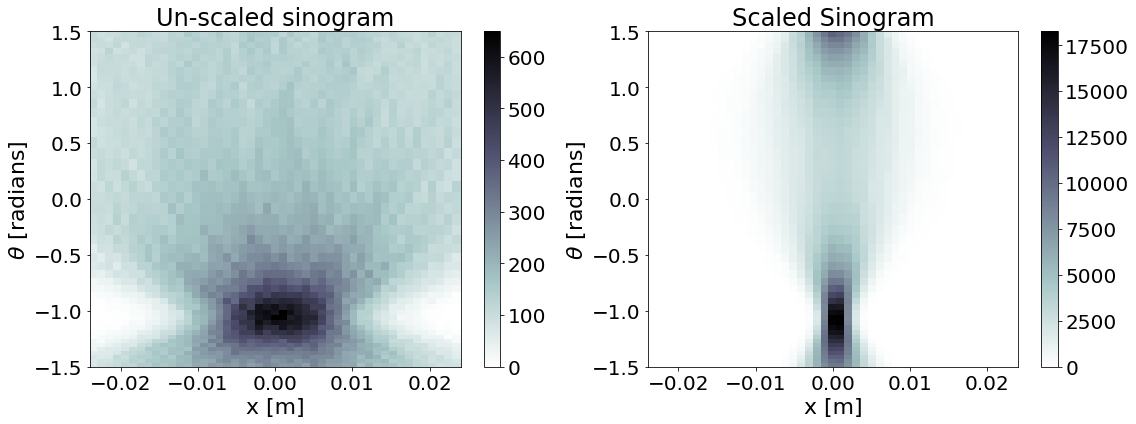

In [125]:
# Generate a sinogram
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Un-scaled sinogram',fontsize=24)
sino_x = x_axis
sino_y = theta_array
xx, yy = np.meshgrid(sino_x,sino_y)
c = np.asarray(profiles)
heatmap = plt.gca().pcolormesh(xx,yy,c,cmap='bone_r');
plt.xlim(low_x_lim,high_x_lim)
plt.ylim(-1.5,1.5)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel(r'$\theta$ [radians]',fontsize=22)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=20)

plt.subplot(122)
plt.title('Scaled Sinogram',fontsize=24)
sino_x = x_axis
sino_y = theta_array
xx, yy = np.meshgrid(sino_x,sino_y)
c = np.asarray(yscaled)
heatmap = plt.gca().pcolormesh(xx,yy,c,cmap='bone_r');
plt.xlim(low_x_lim,high_x_lim)
plt.ylim(-1.5,1.5)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel(r'$\theta$ [radians]',fontsize=22)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

scaled_sino = np.asarray(yscaled)